# Smiths Project 

**RQ: What are the main recurring themes, emotional patterns, and linguistic characteristics present in The Smiths' lyrics, and how do these evolve and perform over their Albums?**

Steps taken:
1. **Data Collection**
   - **Objective**: Gather a comprehensive collection of The Smiths'song and Albums
   - **Challenges**: The Smiths Discography is littered with junk. Struggled with getting just thier actualy songs for a while. The only solution that worked was specifying a list of albums that I wanted to look into. 
2. **Data Cleaning and Preprocessing**
   - **Objective**: Clean and prepare the lyrics data for analysis.
3. **Data Categorization and Theme Identification**
   - **Objective**: Identify main recurring themes in The Smiths’ lyrics.
4. **Sentiment Analysis**
   - **Objective**: Determine the sentiment expressed in each song.
   - **Challenges**: Didnt really like the results of the sentiment analysis since it didnt really get the real sentiment of the songs. I lost all trust when it says a songs called 'Heaven Knows I'm Miserable Know' has a highley positive sentiment. 
5. **Visualization Setup**
   - **Objective**: Visualize the themes and sentiment changes over time.
6. **Analyze and Interpret Results**
   - **Objective**: Deeply interpret the themes and sentiments to uncover insights.
8. **Documentation and Writeup**
   - **Objective**: Document your findings and compile the results into a comprehensive report.

In [94]:
# Import neccessary libraries

import regex as re
import lyricsgenius
import pandas as pd
import requests
import os
from dotenv import load_dotenv
from bs4 import BeautifulSoup

# Define real list of albums since most of the smiths catalog is Live albums and compilations or Movies
ALBUMS = ['The Smiths', 'Meat Is Murder', 'The Queen Is Dead', 'Strangeways, Here We Come', 'Louder Than Bombs', 'Hateful of Hallow']

In [95]:
# Get access token from API's

def get_access_token(url, client_id, client_secret):
    url = url
    data = {
        'client_id': client_id,
        'client_secret': client_secret,
        'grant_type': 'client_credentials'
    }
    response = requests.post(url, data=data)
    response_data = response.json()
    if response.status_code != 200:
        print('Error:', response_data['error'])
        return None
    else:
        print('Access Token:', response_data['access_token'])
        return response_data['access_token']
    

load_dotenv('3510.env')
genius_client_id = os.getenv('GENIUS_CLIENT_ID')
genius_client_secret = os.getenv('GENIUS_SECRET')
genius_access_token = get_access_token(url='https://api.genius.com/oauth/token', client_id=genius_client_id, client_secret=genius_client_secret)

spotify_client_id = os.getenv("SPOTIFY_CLIENT_ID")
spotify_client_secret = os.getenv("SPOTIFY_CLIENT_SECRET")

spotify_access_token = get_access_token(url='https://accounts.spotify.com/api/token', client_id=spotify_client_id, client_secret=spotify_client_secret)

Access Token: ivBLxMiUHRGu4EBcOg6dWEBZ6DOA2_urK7ELeOykcsN2UsT9Id3jI7W1oTKteDw_
Access Token: BQDiOSoa6jl-C03rDgbhyDzLCXW0k21UbjJByhs9uREpkdO5McdIaOgAZfidP7YdIEfXkVcvdI6leslVOnK6KjnNLXBnjFl4Sl40twwncgX61jQAL0I


In [96]:
# Define the Album and Song classes
class Album:
    """ 
    This class represents an album. 

    Attributes:
    name (str): The name of the album.
    artist (str): The artist of the album.
    album_id (str): The album's unique identifier.
    release_date (str): The album's release date.
    total_tracks (int): The total number of tracks on the album.
    songs (list): A list of songs on the album.
    theme (str): The overall theme of the album.
    """
    def __init__(self, name, artist, album_id, release_date, total_tracks):
        self.name = name
        self.artist = artist
        self.album_id = album_id
        self.release_date = release_date
        self.total_tracks = total_tracks
        self.songs = []
        self.theme = None

    def add_song(self, song):
        """
        Add a song to the album.
        """
        self.songs.append(song)

    def description(self):
        """
        Print a description of the album.
        """
        print(f'{self.name} is an album by {self.artist} released on {self.release_date}.') 
        print(f'It contains {len(self.songs)} tracks. The overall theme of the album is {self.theme}.')

    def full_description(self):
        """
        Print a full description of the album and its songs.
        """
        self.description()
        print('The tracklist is:')
        for song in self.songs:
            print(f'{song.track_number}. {song.name}')
            print(f'Duration: {song.duration}')
            print(f'Theme: {song.theme}\n')

class Song:
    """
    This class represents a song. The song is automatically added to the album's song list when created.

    Attributes:
    album (Album): The album the song belongs to.
    name (str): The name of the song.
    artist (str): The artist of the song.
    song_id (str): The song's unique identifier.
    duration_ms (int): The duration of the song in milliseconds.
    explicit (bool): Whether the song contains explicit content.
    track_number (int): The track number of the song on the album.
    lyrics (str): The lyrics of the song.
    theme (str): The theme of the song.
    """
    def __init__(self, album, name, artist, song_id, duration_ms, explicit, track_number):
        self.album = album
        self.name = name
        self.artist = artist
        self.song_id = song_id
        self.duration_ms = duration_ms
        self.duration = pd.to_datetime(self.duration_ms, unit='ms').strftime('%M:%S')
        self.explicit = explicit
        self.track_number = track_number
        self.lyrics = None
        self.theme = None

        # Automatically add the song to the album's song list
        album.add_song(self)

In [97]:
# Get Albums from SpotifyAPI

rootURL = 'https://api.spotify.com/v1/'
headers = {"Authorization":"Bearer "+spotify_access_token}
smiths_search = requests.get(rootURL+'search?q=TheSmiths&type=artist',headers=headers).json()
smiths_id = smiths_search['artists']['items'][0]['id']
smiths_albums = requests.get(rootURL+'artists/'+smiths_id+'/albums',headers=headers).json()

In [98]:
# Assign albums and attributes to Album class

smiths_album_names = [album['name'] for album in smiths_albums['items'] if album['name'] in ALBUMS]
smiths_album_ids = [album['id'] for album in smiths_albums['items'] if album['name'] in ALBUMS]
smithAlbums = []

for i in range(len(smiths_album_names)):
    album = Album(name=smiths_album_names[i], 
                  artist='The Smiths', 
                  album_id=smiths_album_ids[i], 
                  release_date=smiths_albums['items'][i]['release_date'],
                  total_tracks=smiths_albums['items'][i]['total_tracks'])
    smithAlbums.append(album)

In [99]:
# Get songs from each album and assign to Song class
smith_songs_by_album = {}

for i in range(len(smiths_album_ids)):
    all_songs = []
    url = rootURL+'albums/'+smiths_album_ids[i]+'/tracks'
    songs = requests.get(url,headers=headers).json()
    for song in songs['items']:
        album = smithAlbums[i]
        song_name = song['name'].split(' - ')[0] # remove the extra info from the song name
        song_id = song['id']
        duration_ms = song['duration_ms']
        explicit = song['explicit']
        track_number = song['track_number']
        song = Song(album=album,
                    name=song_name, 
                    artist='The Smiths', 
                    song_id=song_id, 
                    duration_ms=duration_ms, 
                    explicit=explicit, 
                    track_number=track_number)
        all_songs.append(song.name)


In [100]:
# Get lyrics for each song

for i,album in enumerate(smithAlbums):
    for j,song in enumerate(album.songs):
        try:
            genius = lyricsgenius.Genius(genius_access_token)
            print("Searching for", song.name)   
            geniusSong = genius.search_song(song.name, "The Smiths")
            song.lyrics = geniusSong.lyrics
        except:
            song.lyrics = None
            print("Lyrics not found for", song.name)


Searching for A Rush and a Push and the Land Is Ours
Searching for "A Rush and a Push and the Land Is Ours" by The Smiths...
Done.
Searching for I Started Something I Couldn't Finish
Searching for "I Started Something I Couldn't Finish" by The Smiths...
Done.
Searching for Death of a Disco Dancer
Searching for "Death of a Disco Dancer" by The Smiths...
Done.
Searching for Girlfriend in a Coma
Searching for "Girlfriend in a Coma" by The Smiths...
Done.
Searching for Stop Me If You Think You've Heard This One Before
Searching for "Stop Me If You Think You've Heard This One Before" by The Smiths...
Done.
Searching for Last Night I Dreamt That Somebody Loved Me
Searching for "Last Night I Dreamt That Somebody Loved Me" by The Smiths...
Done.
Searching for Unhappy Birthday
Searching for "Unhappy Birthday" by The Smiths...
Done.
Searching for Paint a Vulgar Picture
Searching for "Paint a Vulgar Picture" by The Smiths...
Done.
Searching for Death at One's Elbow
Searching for "Death at One's E

In [101]:
# Create a DataFrame and save to CSV so I dont have to wait 8 minutes to get the data again

albums_df = pd.DataFrame(columns=['Album Name', 'Artist', 'Release Date', 'Total Tracks', 'Song Name', 'Duration (ms)', 'Explicit', 'Track Number', 'Lyrics'])
for album in smithAlbums:
    for song in album.songs:
        if song.lyrics is None:
            continue
        else:
            song_data = pd.DataFrame([[album.name, song.artist, album.release_date, album.total_tracks, song.name, song.duration_ms, song.explicit, song.track_number, song.lyrics]], columns=['Album Name', 'Artist', 'Release Date', 'Total Tracks', 'Song Name', 'Duration (ms)', 'Explicit', 'Track Number', 'Lyrics'])
            albums_df = pd.concat([albums_df, song_data], ignore_index=True)
albums_df.to_csv('smiths_albums.csv', index=False)

In [102]:
# Clean up the lyrics column 
for index, row in albums_df.iterrows():
    try:
        # Handle columns with and without brackets diffrently 
        if '[' in row['Lyrics']:
            # Split on only the first occurrence of ']' and keep only the second part
            lyrics = row['Lyrics'].split(']', 1)[1]
            # Split on only the last occurrence of '[' and keep only the first part
            lyrics = lyrics.rsplit('[', 1)[0]
            # Use regex to remove all text in brackets
            pattern = r'\[.*?\]'
            lyrics = re.sub(pattern, ' ', lyrics)

            # Alter the DataFrame
            albums_df.at[index, 'Lyrics'] = lyrics
        else: 
            # Split on only the first occurrence of 'Lyrics' and keep only the second part
            lyrics = row['Lyrics'].split('Lyrics', 1)[1]
            # Split on only the last occurrence of 'E' for Embedded and keep only the first part
            lyrics = lyrics.rsplit('E', 1)[0]
            albums_df.at[index, 'Lyrics'] = lyrics
    except:
        print('Error cleaning lyrics for', row['Song Name'])
        pass

In [103]:
# Clean up the lyrics column 

for index, row in albums_df.iterrows():
    try:
        # Handle columns with and without brackets diffrently 
        if '[' in row['Lyrics']:
            # Split on only the first occurrence of ']' and keep only the second part
            lyrics = row['Lyrics'].split(']', 1)[1]
            # Split on only the last occurrence of '[' and keep only the first part
            lyrics = lyrics.rsplit('[', 1)[0]
            # Use regex to remove all text in brackets
            pattern = r'\[.*?\]'
            lyrics = re.sub(pattern, ' ', lyrics)

            # Alter the DataFrame
            albums_df.at[index, 'Lyrics'] = lyrics
        else: 
            # Split on only the first occurrence of 'Lyrics' and keep only the second part
            lyrics = row['Lyrics'].split('Lyrics', 1)[1]
            # Split on only the last occurrence of 'E' for Embedded and keep only the first part
            lyrics = lyrics.rsplit('E', 1)[0]
            albums_df.at[index, 'Lyrics'] = lyrics
    except:
        print('Error cleaning lyrics for', row['Song Name'])
        pass

Error cleaning lyrics for A Rush and a Push and the Land Is Ours
Error cleaning lyrics for I Started Something I Couldn't Finish
Error cleaning lyrics for Death of a Disco Dancer
Error cleaning lyrics for Girlfriend in a Coma
Error cleaning lyrics for Stop Me If You Think You've Heard This One Before
Error cleaning lyrics for Last Night I Dreamt That Somebody Loved Me
Error cleaning lyrics for Unhappy Birthday
Error cleaning lyrics for Paint a Vulgar Picture
Error cleaning lyrics for Death at One's Elbow
Error cleaning lyrics for I Won't Share You
Error cleaning lyrics for The Queen Is Dead
Error cleaning lyrics for Frankly, Mr. Shankly
Error cleaning lyrics for I Know It's Over
Error cleaning lyrics for Never Had No One Ever
Error cleaning lyrics for Cemetry Gates
Error cleaning lyrics for Bigmouth Strikes Again
Error cleaning lyrics for The Boy with the Thorn in His Side
Error cleaning lyrics for Vicar in a Tutu
Error cleaning lyrics for There Is a Light That Never Goes Out
Error cle

In [104]:
# Clean lyrics column further not based on any conditions

albums_df['Lyrics'] = albums_df['Lyrics'].str.replace('\n', ' ')

# Use regex to remove descriptors in the lyrics (*applause*)
pattern = r'\*.*?\*'
albums_df['Lyrics'] = albums_df['Lyrics'].apply(lambda x: re.sub(pattern, ' ', x) if x is not None else None)

In [105]:
# Tokenize and remove stop words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


stop_words = set(stopwords.words('english'))

# Define a function to tokenize and remove stop words
def tokenize_and_remove_stopwords(text):
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stop words
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return filtered_words

# Apply the function to the 'Lyrics' column
albums_df['Tokenized Lyrics'] = albums_df['Lyrics'].apply(tokenize_and_remove_stopwords)


In [106]:
# albums_df.to_csv('smiths_albums_cleaned.csv', index=False)
# albums_df = pd.read_csv('smiths_albums_cleaned.csv')

In [107]:
# Do sentiment analysis on the lyrics

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Example of tokenized and cleaned lyrics
lyrics = albums_df['Tokenized Lyrics'][albums_df['Song Name'] == "Death of a Disco Dancer"].tolist()[0]
print(lyrics)
# Combine tokens into a single string
lyrics_str = " ".join(lyrics)

# Get sentiment scores
sentiment = analyzer.polarity_scores(lyrics_str)

print(f"Sentiment Scores: {sentiment}")


['death', 'disco', 'dancer', 'Well', ',', 'happens', 'lot', "'round", 'think', 'peace', 'common', 'goal', 'goes', 'show', 'little', 'know', 'death', 'disco', 'dancer', 'Well', ',', "'d", 'rather', 'get', 'involved', 'never', 'talk', 'neighbour', "'d", 'rather', 'get', 'involved', '(', 'Oh-oh-oh-oh', ')', '(', 'Oh-oh-oh-oh-oh', ')', 'Love', ',', 'peace', 'harmony', '?', 'Love', ',', 'peace', 'harmony', '?', 'Oh', ',', 'nice', ',', 'nice', 'nice', ',', 'nice', 'maybe', 'next', 'world', 'Love', ',', 'peace', 'harmony', '?', 'Love', ',', 'peace', 'harmony', '?', 'Oh', ',', 'nice', ',', 'nice', 'nice', ',', 'nice', ',', 'nice', 'maybe', 'next', 'world', ',', 'maybe', 'next', 'world', 'Maybe', 'next', 'world', 'Love', ',', 'peace', 'harmony', '?', 'Love', ',', 'peace', 'harmony', '?', 'Oh', ',', 'nice', ',', 'nice', ',', 'nice', 'maybe', 'next', 'world', 'Maybe', 'next', 'world', 'might', 'also', 'like', '(', 'next', 'world', ',', 'next', 'world', ')', '(', 'next', 'world', ',', 'next', 'wor

In [108]:
# Define a function to get the theme of a song

def get_theme(lyrics,themeCount=False):
    """
    Get the theme of a song based on its lyrics.
    """
    # Initialize theme counts
    themes_dict = {
        'Love': [
            'heart', 'romance', 'longing', 'desire', 'affection', 'passion', 'embrace','entwined',
            'adore', 'devotion', 'infatuation', 'kiss', 'hold', 'darling', 'beloved', 'lovers','love',
            'sweetheart','loving','loved', 'sweetness', 'caring', 'care', 'cared', 'cute', 'caring', 'caringly',
            'liked','chasing','girl','lips'
        ],
        'Death': [
            'grave', 'funeral', 'mourning', 'loss', 'farewell', 'mortality', 'passing',
            'eternal', 'heaven', 'soul', 'tomb', 'afterlife', 'grief', 'dark','die','kills',
            'death','dead','died'
        ],
        'Joy': [
            'joy', 'smile', 'delight', 'laughter', 'euphoria', 'bliss', 'cheer', 'contentment',
            'bright', 'elation', 'sun', 'shine', 'celebration', 'free','happy','happiness'
        ],
        'Sorrow': [
            'tears', 'sorrow', 'melancholy', 'despair', 'heartbreak', 'loneliness', 'grief',
            'blue', 'gloom', 'cry', 'lament', 'misery', 'cold', 'lonely', 'miserable','please',
            'sad','sadness','pain','saddest', 'alone', 'feel', 'felt','forgotten'
        ]
    }
    theme_counts = {theme: 0 for theme in themes_dict.keys()}
    for word in lyrics:
        for theme, keywords in themes_dict.items():
            if word.lower() in keywords:
                theme_counts[theme] += 1
    # Get the theme with the highest count
    theme = max(theme_counts, key=theme_counts.get)
    if theme == 'love' and theme_counts[theme] == 0:
        theme = 'neutral'
    if themeCount:
        return theme_counts
    else:
        return theme

albums_df['Theme'] = albums_df['Tokenized Lyrics'].apply(get_theme)
albums_df['Theme Count'] = albums_df['Tokenized Lyrics'].apply(lambda x: get_theme(x, themeCount=True))
albums_df['Raw Theme'] = albums_df['Lyrics'].apply(lambda x: get_theme(x.strip().split()))
albums_df['Raw Theme Count'] = albums_df['Lyrics'].apply(lambda x: get_theme(x, themeCount=True))
albums_df['Sentiment'] = albums_df['Lyrics'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
albums_df['Tokenized Sentiment'] = albums_df['Tokenized Lyrics'].apply(lambda x: analyzer.polarity_scores(" ".join(x))['compound'])

In [109]:
# Assign themes to songs in the Album class

for album in smithAlbums:
    for song in album.songs:
        try:
            song.theme = albums_df['Theme'][albums_df['Song Name'] == song.name].tolist()[0]
        except:
            print('Theme not found for', song.name)
            pass
albums_df['Theme'].value_counts()

Theme not found for Oscillate Wildly
Theme not found for Rubber Ring
Theme not found for Back to the Old House
Theme not found for Stretch out and Wait


Theme
Love      29
Sorrow    14
Death     10
Joy        2
Name: count, dtype: int64

In [110]:
# Get the most common words in the lyrics

wordUsage = {}
for index, row in albums_df.iterrows():
    for word in row['Tokenized Lyrics']:
        word = word.lower()
        if word in [',',"'",'"','(',')','.',':',';','?','!',"'s","n't","``",'"',"'m","'ll","'re","'ve","''"]:
            continue
        elif word in wordUsage:
            wordUsage[word] += 1
        else:
            wordUsage[word] = 1
        
wordUsage = pd.DataFrame(wordUsage.items(), columns=['Word', 'Count'])
wordUsage = wordUsage.sort_values('Count', ascending=False)
wordUsage.head(10)

,Word,Count
91,oh,181
53,like,83
80,never,79
37,love,75
116,know,68
51,might,60
27,life,51
20,said,48
52,also,46
133,really,39


In [111]:
# Assign themes to albums in the Album class
album_theme = {}
for i,album in enumerate(albums_df['Album Name'].unique()):
    album_theme[album] = albums_df['Theme'][albums_df['Album Name'] == album].value_counts().idxmax()
    albums_df['Album Theme'] = albums_df['Album Name'].map(album_theme)
    smithAlbums[i].theme = album_theme[album]

In [112]:
albums_df.head()

,Album Name,Artist,Release Date,Total Tracks,Song Name,Duration (ms),Explicit,Track Number,Lyrics,Tokenized Lyrics,Theme,Theme Count,Raw Theme,Raw Theme Count,Sentiment,Tokenized Sentiment,Album Theme
0,"Strangeways, Here We Come",The Smiths,1988-09-05,14,A Rush and a Push and the Land Is Ours,183013,False,1,Hello I am the ghost of Troubled Joe Hung by ...,"[Hello, ghost, Troubled, Joe, Hung, pretty, wh...",Love,"{'Love': 4, 'Death': 0, 'Joy': 0, 'Sorrow': 3}",Love,"{'Love': 0, 'Death': 0, 'Joy': 0, 'Sorrow': 0}",-0.9943,-0.9852,Love
1,"Strangeways, Here We Come",The Smiths,1988-09-05,14,I Started Something I Couldn't Finish,227533,False,2,"The lanes were silent There was nothing, no o...","[lanes, silent, nothing, ,, one, ,, nothing, a...",Love,"{'Love': 0, 'Death': 0, 'Joy': 0, 'Sorrow': 0}",Love,"{'Love': 0, 'Death': 0, 'Joy': 0, 'Sorrow': 0}",-0.5651,0.8180,Love
2,"Strangeways, Here We Come",The Smiths,1988-09-05,14,Death of a Disco Dancer,326253,False,3,"The death of a disco dancer Well, it happens ...","[death, disco, dancer, Well, ,, happens, lot, ...",Love,"{'Love': 6, 'Death': 5, 'Joy': 0, 'Sorrow': 0}",Death,"{'Love': 0, 'Death': 0, 'Joy': 0, 'Sorrow': 0}",0.9986,0.9978,Love
3,"Strangeways, Here We Come",The Smiths,1988-09-05,14,Girlfriend in a Coma,122760,False,4,"Girlfriend in a coma, I know I know, it's ser...","[Girlfriend, coma, ,, know, know, ,, 's, serio...",Sorrow,"{'Love': 0, 'Death': 0, 'Joy': 0, 'Sorrow': 1}",Sorrow,"{'Love': 0, 'Death': 0, 'Joy': 0, 'Sorrow': 0}",-0.9480,-0.9420,Love
4,"Strangeways, Here We Come",The Smiths,1988-09-05,14,Stop Me If You Think You've Heard This One Before,215573,False,5,"Stop me, oh-oho, stop me Stop me if you think...","[Stop, ,, oh-oho, ,, stop, Stop, think, 've, h...",Love,"{'Love': 3, 'Death': 0, 'Joy': 0, 'Sorrow': 1}",Love,"{'Love': 0, 'Death': 0, 'Joy': 0, 'Sorrow': 0}",-0.9818,-0.9763,Love


In [113]:
albums_df[albums_df['Theme'] != albums_df['Raw Theme']]

,Album Name,Artist,Release Date,Total Tracks,Song Name,Duration (ms),Explicit,Track Number,Lyrics,Tokenized Lyrics,Theme,Theme Count,Raw Theme,Raw Theme Count,Sentiment,Tokenized Sentiment,Album Theme
2,"Strangeways, Here We Come",The Smiths,1988-09-05,14,Death of a Disco Dancer,326253,False,3,"The death of a disco dancer Well, it happens ...","[death, disco, dancer, Well, ,, happens, lot, ...",Love,"{'Love': 6, 'Death': 5, 'Joy': 0, 'Sorrow': 0}",Death,"{'Love': 0, 'Death': 0, 'Joy': 0, 'Sorrow': 0}",0.9986,0.9978,Love
15,The Queen Is Dead,The Smiths,1987-09-28,10,Bigmouth Strikes Again,193320,False,6,"Sweetness, sweetness I was only joking when I...","[Sweetness, ,, sweetness, joking, said, 'd, li...",Love,"{'Love': 4, 'Death': 0, 'Joy': 0, 'Sorrow': 4}",Sorrow,"{'Love': 0, 'Death': 0, 'Joy': 0, 'Sorrow': 0}",0.9042,0.9393,Love


In [114]:
# Create a bar chart of the themes

import altair as alt

theme_counts = albums_df['Raw Theme'].value_counts().reset_index()
theme_counts.columns = ['Theme', 'Count']

theme_chart = alt.Chart(theme_counts).mark_bar().encode(
    x='Count:Q',
    y=alt.Y('Theme:N', sort='-x')
).properties(
    title=alt.TitleParams('Themes in The Smiths Lyrics', 
                          subtitle='Based on the most common words in the lyrics')
).configure_title(
    fontSize=20,
    font='Courier',
    anchor='start',
    color='black'
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_legend(
    titleFontSize=14,
    labelFontSize=12
).configure_view(
    strokeWidth=0
).display()


alt.Chart(...)

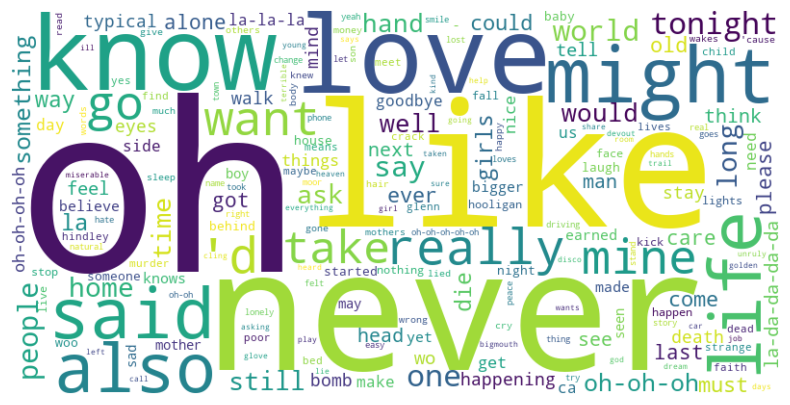

In [115]:
# Create a word cloud of the smiths lyrics

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordUsage.set_index('Word')['Count'])

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [116]:
smithAlbums[4].full_description()

Louder Than Bombs is an album by The Smiths released on 1985-02-11.
It contains 20 tracks. The overall theme of the album is Love.
The tracklist is:
1. Is It Really so Strange?
Duration: 03:08
Theme: Sorrow

2. Sheila Take a Bow
Duration: 02:42
Theme: Love

3. Shoplifters of the World Unite
Duration: 02:58
Theme: Love

4. Sweet and Tender Hooligan
Duration: 03:36
Theme: Love

5. Half a Person
Duration: 03:38
Theme: Love

6. London
Duration: 02:07
Theme: Sorrow

7. Panic
Duration: 02:20
Theme: Love

8. Girl Afraid
Duration: 02:46
Theme: Love

9. Shakespeare's Sister
Duration: 02:08
Theme: Love

10. William, It Was Really Nothing
Duration: 02:11
Theme: Love

11. You Just Haven't Earned It Yet, Baby
Duration: 03:33
Theme: Sorrow

12. Heaven Knows I'm Miserable Now
Duration: 03:35
Theme: Death

13. Ask
Duration: 03:18
Theme: Love

14. Golden Lights
Duration: 02:41
Theme: Love

15. Oscillate Wildly
Duration: 03:28
Theme: None

16. These Things Take Time
Duration: 02:23
Theme: Love

17. Rubb